In [54]:
##1
## Importing Modules

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm #just to get the progress bar 
warnings.filterwarnings('ignore')

%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D ,Dropout, Flatten, MaxPooling2D, Input


In [59]:
##2 (CHANGER LA DIRECTORY)
## Load Dataset

BASE_DIR=r"C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset"

In [60]:
##3
#labels: race, gender, ethnicity

image_paths=[]
age_labels=[]
gender_labels=[]


for filename in tqdm(os.listdir(BASE_DIR)): #iterates in all the files inside the direcetory
    image_path=os.path.join(BASE_DIR,filename)
    temp=filename.split('_') #on split le nom de l'image selon les _ pour avoir age , date etc..
    age =int(temp[0])#premier element de la liste
    gender =int(temp[1])#second element de la liste
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    
    #la barre en bas montre que we loaded all the images 
    

  0%|          | 0/24108 [00:00<?, ?it/s]

ValueError: invalid literal for int() with base 10: ''

In [57]:
##4
#convert my images into a data frame
df=pd.DataFrame()
df['image'],df['age'],df['gender']=image_paths, age_labels, gender_labels # ce sont les colonnes de mon dataframe
df.head() #cette commande nous permet de voir les premieres lignes, on a creer a proper dataframe


,image,age,gender


In [58]:
##5
#define labels of gender
gender_dict={0:'Male',1:'Female'}

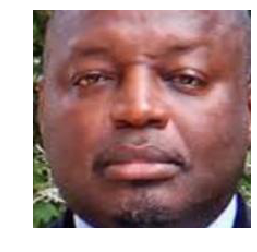

In [24]:
##6
# Exploratory Data Analysis
from PIL import Image  # PIL est un module utilise pour loader des images 
img= Image.open(df['image'][0]) #on ouvre juste la premiere image
plt.axis('off')
plt.imshow(img);
#for better image preproceessing et ne pas surcharge la RAM, La RAM EST LIMTE on utilise grayscale et on la reesize

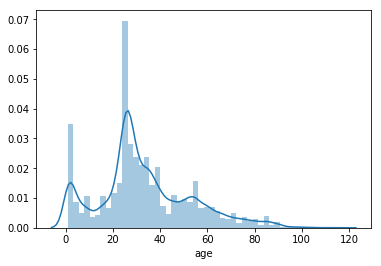

In [25]:
##7
## Class dstributioon selon l'age

sns.distplot(df['age'])

#On peut utiliser standard scaler ou la normalizaton pour avoir els ages engtre 0 et 1 

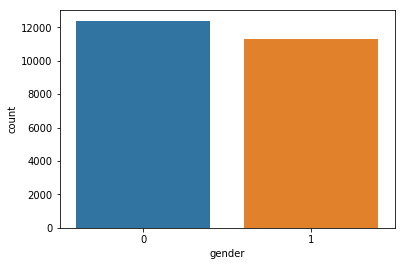

In [26]:
##8
## Class distribution selon le genre
sns.countplot(x= df['gender'], data=df)


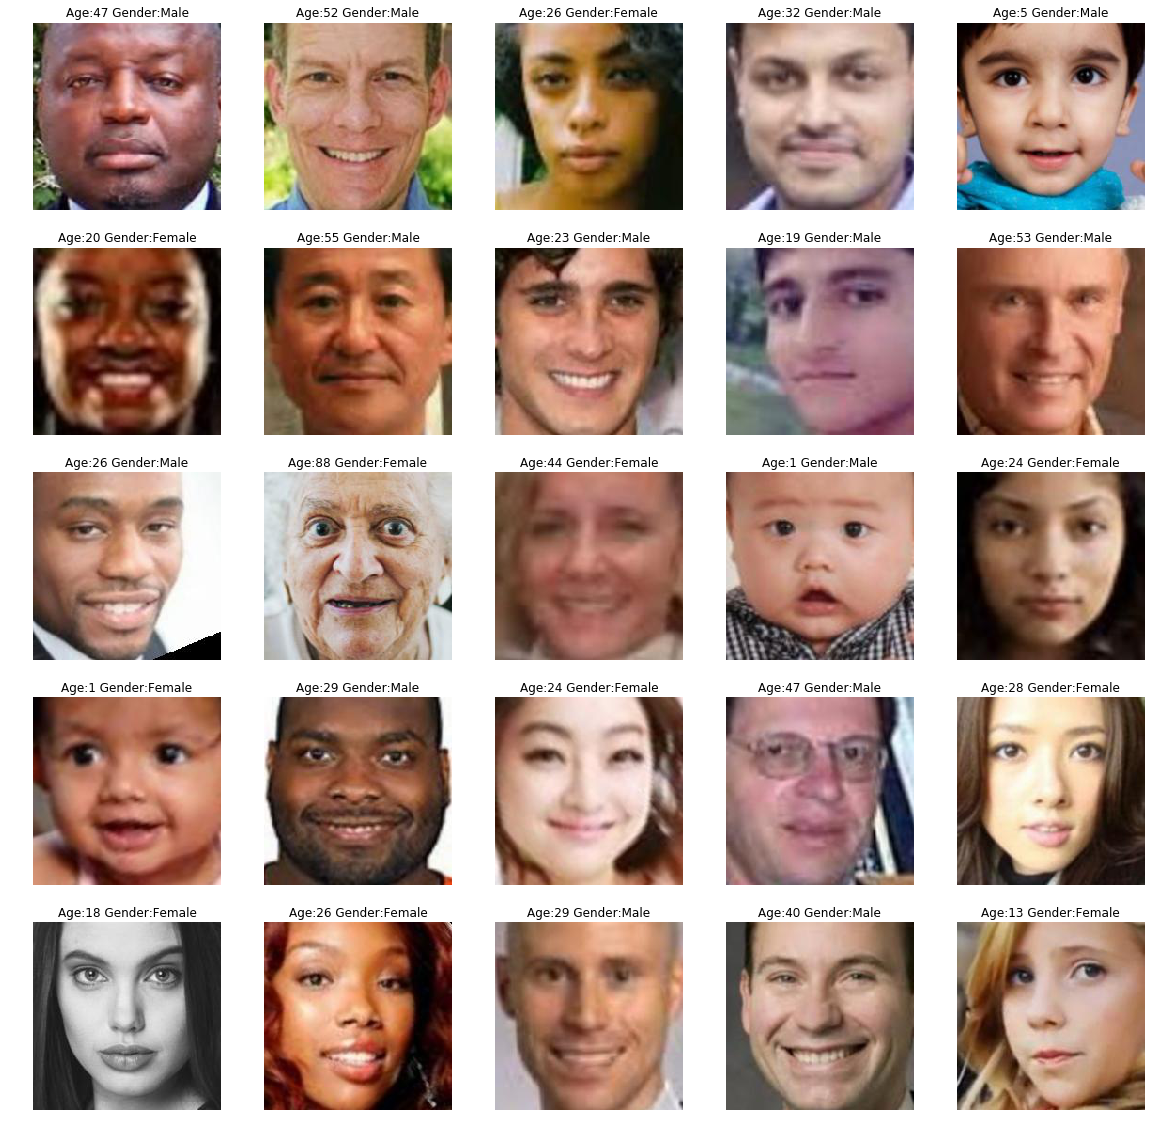

In [27]:
##9
#display a grid of images
plt.figure(figsize=(20,20))
files=df.iloc[0:25]#on prend les 25 premieres images

for index,file,age, gender in files.itertuples(): #we iterate in the file, age and gender columns
    plt.subplot(5,5 ,index+1)
    img=load_img(file)
    img=np.array(img)
    plt.imshow(img)
    plt.title(f"Age:{age} Gender:{gender_dict[gender]}")
    plt.axis('off')



In [29]:
##10
## Extracting features
from tensorflow.keras.preprocessing.image import load_img

def extract_features(images):
    features=[]
    for image in tqdm (images):
         #on ne peux pas  se permettre de load toutes les images en RGB: 3 dimensions  et prendre toute la memoire
        img = load_img(image)
        #img = load_img(image, color_mode='grayscale')
        img=img.resize((128,128),Image.ANTIALIAS)
        img=np.array(img)
        features.append(img)
        
    #we convert the features to a numpy array
    features=np.array(features) # cette etape est obligatoire car les neurals network gere que les array 
    features=features.reshape(len(features),128,128,3) #ca prend en arguments number fo features, width, height et la dimension
    # dans notre cas grayscale image ducoup dimension=1
    #dans le cas ou on sera rester en RGB, on oublie ceci 
    return features 
    
        

In [30]:
##11
X=extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [31]:
##12
X.shape
#on verifie bien que la dernier valeur est 1 cad il est en graycale

(23708, 128, 128, 3)

In [32]:
##13
#normalize the images 
X=X/255.0 #la valeur dee la pixel est de 0-255 maintenant  elle sera de la range 0 to 1 

In [33]:
##14
y_gender=np.array(df['gender']) #on convertit to numpy
y_age=np.array(df['age']) #on convertir to numpy 

In [34]:
##15
input_shape=(128,128,3)

In [ ]:
##16
## CHARACTERISTIQUE MODEL 1
from keras.applications import VGG16

vgg16 = VGG16(weights=None, include_top=False, input_shape=(128,128,3))
#premier problemee les poids jee n'arrivais pas les rammener
#second probleme VGG16 est fait pour les photos en RGB
# Téléchargement des poids pré-entraînés VGG16
#from keras.utils import get_file
#weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5','https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',cache_subdir='models')
#vgg16.load_weights(weights_path, by_name=True) 

#vous spécifiez que vous voulez utiliser les poids pré-entraînés de ce modèle sur l'ensemble de données ImageNet
#L'utilisation de poids pré-entraînés sur ImageNet pour initialiser votre modèle peut être bénéfique pour plusieurs raisons :ransfert de connaissances (Transfer Learning) 
#Optimisation plus rapide eet Généralisation améliorée 

#vous chargez VGG16 avec include_top=False, cela signifie que vous ne chargez pas la couche 
#de classification finale de VGG16, mais seulement les couches convolutives de base.
# la partie finale qui est spécifique à la classification d'ImageNet. donc il faut l'enlever

for layer in vgg16.layers:
    layer.trainable = False
    
#Cela empêche les poids des couches VGG16 d'être mis à jour pendant l'entraînement.
#Nous voulons conserver les représentations apprises par VGG16 et ne pas les modifier.

x = Flatten()(vgg16.output)#onvertir la sortie de la dernière couche convolutive de VGG16 en un vecteur plat.
x = Dense(256, activation='relu')(x) #ajout de couche personaliser
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)
age_output = Dense(1, activation='linear', name='age_output')(x)

# VGG16

In [ ]:

#CREATION MODEL 1


# Charger les données d'entraînement X et les étiquettes y_gender, y_age

# Assurez-vous que vos données d'entrée sont chargées en niveaux de gris ou en RGB en fonction des besoins du modèle.
# Si vos images sont déjà en niveaux de gris et que votre modèle attend des images RGB, vous devrez les convertir en images RGB.

# Dans cet exemple, supposons que X contient des images en niveaux de gris et que votre modèle attend des images RGB.



# Créer le modèle en spécifiant les entrées et les sorties
model = Model(inputs=vgg16.input, outputs=[gender_output, age_output])
#Nous créons un modèle en spécifiant les entrées (les images) et les sorties (le genre et l'âge) du modèle.

# Compiler le modèle avec les fonctions de perte et les métriques appropriées
model.compile(optimizer='adam',
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mean_squared_error'},
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})


#La compilation du modèle est l'étape où vous configurez les détails d'apprentissage de votre réseau neuronal.
#Cela comprend le choix de l'optimiseur, des fonctions de perte et des métriques à utiliser pendant l'entraînement

# Entraîner le modèle avec les données d'entraînement
history = model.fit(X, {'gender_output': y_gender, 'age_output': y_age},
                    validation_split=0.2,
                    epochs=10,
                    batch_size=32)



In [ ]:
'''loss, gender_loss, age_loss, gender_accuracy, age_mae = model.evaluate(X, {'gender_output': y_gender, 'age_output': y_age})
print("Loss:", loss)
print("Gender Loss:", gender_loss)
print("Age Loss:", age_loss)
print("Gender Accuracy:", gender_accuracy)
print("Age MAE:", age_mae)

'''

# MobileNET avec poids de base

In [ ]:
'''
#CREATION MODEL 2

from keras.applications import MobileNet
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense

# Charger le modèle MobileNet pré-entraîné sans les couches fully connected
base_model = MobileNet(weights=None, include_top=False, input_shape=(128, 128, 3))

# Télécharger les poids pré-entraînés à partir d'une source fiable et les charger localement
#weights_path = '/chemin/vers/les/poids/locaux/mobilenet_1_0_128_tf_no_top.h5'
#base_model.load_weights(weights_path)


# Geler les poids des couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches fully connected personnalisées au modèle
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
# Ajouter la sortie pour la prédiction du genre
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)
# Ajouter la sortie pour la prédiction de l'âge
age_output = Dense(1, activation='linear', name='age_output')(x)

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=[gender_output, age_output])

# Compiler le modèle
model.compile(optimizer='adam',
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mean_squared_error'},
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})


'''

# Tracer les courbes de perte
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Tracer les courbes de précision
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# MobileNET V1

In [ ]:
from keras.applications import MobileNet
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense

# Charger le modèle MobileNetV1 pré-entraîné avec les poids pré-entraînés
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Geler les poids des couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches fully connected personnalisées au modèle
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
# Ajouter la sortie pour la prédiction du genre
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)
# Ajouter la sortie pour la prédiction de l'âge
age_output = Dense(1, activation='linear', name='age_output')(x)

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=[gender_output, age_output])

# Compiler le modèle
model.compile(optimizer='adam',
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mean_squared_error'},
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})


# MobileNET V2 

In [ ]:
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense

# Charger le modèle MobileNetV2 pré-entraîné avec les poids pré-entraînés
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Geler les poids des couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches fully connected personnalisées au modèle
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
# Ajouter la sortie pour la prédiction du genre
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)
# Ajouter la sortie pour la prédiction de l'âge
age_output = Dense(1, activation='linear', name='age_output')(x)

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=[gender_output, age_output])

# Compiler le modèle
model.compile(optimizer='adam',
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mean_squared_error'},
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})


# Modele Personelle 

In [36]:

#CREATION MODEL 3
inputs = Input((input_shape))
#convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])



# plot the model
#from tensorflow.keras.utils import plot_model
#plot_model(model)






In [37]:

from tensorflow.keras.callbacks import ModelCheckpoint

#Define the callback
checkpoint_callback = ModelCheckpoint(
    filepath='ModelPersonelAgeSex.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)
checkpoint_callback = ModelCheckpoint(
    filepath='ModelPersonelAgeSex.weights.h5',
    monitor='val_gender_out_accuracy',  # Use the correct output accuracy for monitoring
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)



In [38]:

# Entraîner le modèle
history = model.fit(x=X, y=[y_gender,y_age],epochs=5,batch_size=32,validation_split=0.2,callbacks=[checkpoint_callback])



# Vous pouvez également prédire les sorties pour de nouvelles données
#predictions = model.predict(new_data)



Train on 18966 samples, validate on 4742 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
18966/18966 [==============================] - 254s 13ms/sample - loss: 15.9514 - gender_out_loss: 0.6940 - age_out_loss: 15.2573 - gender_out_acc: 0.5550 - gender_out_mean_absolute_error: 0.4838 - age_out_acc: 0.0469 - age_out_mean_absolute_error: 15.2573 - val_loss: 13.6019 - val_gender_out_loss: 0.5705 - val_age_out_loss: 13.0314 - val_gender_out_acc: 0.7166 - val_gender_out_mean_absolute_error: 0.4096 - val_age_out_acc: 0.0489 - val_age_out_mean_absolute_error: 13.0314
Epoch 2/5
18966/18966 [==============================] - 253s 13ms/sample - loss: 11.8437 - gender_out_loss: 0.4982 - age_out_loss: 11.3455 - gender_out_acc: 0.7602 - gender_out_mean_absolute_error: 0.3344 - age_out_acc: 0.0313 - age_out_mean_absolute_error: 11.3455 - val_loss: 11.1972 - val_gender_out_loss: 0.4233 - val_age_out_loss: 10.7739 - val_gender_out_acc: 0.7931 - val_gender_out_mean_absolute_error: 0.2

In [40]:
model.save("zser.h5")

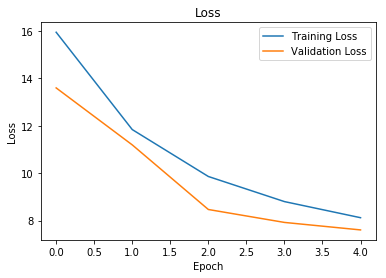

KeyError: 'accuracy'

In [39]:
#Tracer les coourbes de perte et de precision
import matplotlib.pyplot as plt

# Tracer les courbes de perte
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model
inputs = Input(shape=(input_shape))
# Convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(maxp_4)

# Fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

# Define the callback
checkpoint_callback = ModelCheckpoint(
    filepath='ModelPersonelAgeSex.weights.h5',
    monitor='val_gender_out_accuracy',  # Use the correct output accuracy for monitoring
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

# Train the model
history = model.fit(x=X, y=[y_gender, y_age], epochs=5, batch_size=32, validation_split=0.2, callbacks=[checkpoint_callback])

# Plotting the accuracy
def plot_accuracy(history):
    # Plot accuracy for gender prediction
    plt.plot(history.history['gender_out_accuracy'], label='Gender Training Accuracy')
    plt.plot(history.history['val_gender_out_accuracy'], label='Gender Validation Accuracy')
    
    # Plot accuracy for age prediction
    plt.plot(history.history['age_out_mae'], label='Age Training MAE')
    plt.plot(history.history['val_age_out_mae'], label='Age Validation MAE')
    
    plt.title('Model Accuracy and MAE')
    plt.ylabel('Accuracy / MAE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_accuracy(history)

# You can also predict the outputs for new data
# predictions = model.predict(new_data)

plt.ylabel('Loss')
plt.legend()
plt.show()

# Tracer les courbes de précision
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
#Comparer les performnances sur les donnees test
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

In [ ]:
#utiliser la valisation croisee
from sklearn.model_selection import cross_val_score

# Définir votre modèle
model = ...

# Évaluer le modèle avec validation croisée
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-Validation Scores:", scores)
print("Mean CV Score:", scores.mean())

In [ ]:
#Controle des hyperparametre
from sklearn.model_selection import GridSearchCV

# Définir la grille des hyperparamètres
param_grid = {...}

# Créer un objet GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5)

# Exécuter la recherche d'hyperparamètres
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Best Parameters:", grid_search.best_params_)

# VGG19

In [ ]:
#CREATION MODEL 4
from keras.applications import VGG19
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense

# Charger les données d'entraînement X et les étiquettes y_gender, y_age
# Assurez-vous que vos données sont chargées et prétraitées correctement

# Créer le modèle VGG19 en spécifiant les entrées et les sorties
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Geler les poids des couches du modèle de base
for layer in vgg19.layers:
    layer.trainable = False

# Ajouter des couches fully connected personnalisées au modèle
x = vgg19.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
# Ajouter la sortie pour la prédiction du genre
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)
# Ajouter la sortie pour la prédiction de l'âge
age_output = Dense(1, activation='linear', name='age_output')(x)

# Créer le modèle final
model = Model(inputs=vgg19.input, outputs=[gender_output, age_output])

# Compiler le modèle avec les fonctions de perte et les métriques appropriées
model.compile(optimizer='adam',
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mean_squared_error'},
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})

# Entraîner le modèle avec les données d'entraînement
history = model.fit(X, {'gender_output': y_gender, 'age_output': y_age},
                    validation_split=0.2,
                    epochs=10,
                    batch_size=32)


# RESNET 50

In [ ]:
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense

# Charger le modèle ResNet50 pré-entraîné avec les poids ImageNet
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les poids des couches du modèle de base
for layer in resnet50.layers:
    layer.trainable = False

# Ajouter des couches fully connected personnalisées au modèle
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
# Ajouter la sortie pour la prédiction du genre
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)
# Ajouter la sortie pour la prédiction de l'âge
age_output = Dense(1, activation='linear', name='age_output')(x)

# Créer le modèle final
model = Model(inputs=resnet50.input, outputs=[gender_output, age_output])

# Compiler le modèle avec les fonctions de perte et les métriques appropriées
model.compile(optimizer='adam',
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mean_squared_error'},
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})

# Entraîner le modèle avec les données d'entraînement
history = model.fit(X, {'gender_output': y_gender, 'age_output': y_age},
                    validation_split=0.2,
                    epochs=10,
                    batch_size=32)


# Separation modele age et genre 

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense

# Fonction pour créer le modèle d'estimation de l'âge
def create_age_estimation_model(input_shape=(224, 224, 1), num_classes=7):
    inputs = Input(shape=input_shape)
    
    # Couches de convolution et de pooling
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    
    # Couche dense pour l'estimation de l'âge
    x = Dense(132, activation='relu')(x)
    age_output = Dense(num_classes, activation='softmax', name='age_output')(x)
    
    model = Model(inputs=inputs, outputs=age_output)
    return model

# Fonction pour créer le modèle de classification du genre
def create_gender_classification_model(input_shape=(64, 64, 3), num_classes=3):
    inputs = Input(shape=input_shape)
    
    # Couches de convolution et de pooling
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    
    # Couche dense pour la classification du genre
    x = Dense(132, activation='relu')(x)
    gender_output = Dense(num_classes, activation='softmax', name='gender_output')(x)
    
    model = Model(inputs=inputs, outputs=gender_output)
    return model

# Créer le modèle d'estimation de l'âge
age_model = create_age_estimation_model(input_shape=(224, 224, 1), num_classes=7)

# Créer le modèle de classification du genre
gender_model = create_gender_classification_model(input_shape=(64, 64, 3), num_classes=3)


In [ ]:
##Mettre une image personeelle


from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input, decode_predictions
import numpy as np

# Charger l'image
img_path = 'chemin/vers/votre/image.jpg'
img = image.load_img(img_path, target_size=(128, 128))

# Convertir l'image en tableau numpy
img_array = image.img_to_array(img)

# Élargir les dimensions de l'image pour correspondre à celles attendues par le modèle
img_array = np.expand_dims(img_array, axis=0)

# Prétraiter l'image
img_array = preprocess_input(img_array)

# Faire la prédiction
predictions = model.predict(img_array)

# Décoder les prédictions
gender_prediction, age_prediction = predictions

# Afficher les résultats
print("Prédiction du genre (0 pour homme, 1 pour femme) :", gender_prediction)
print("Prédiction de l'âge :", age_prediction)



# MODELE PERSONELLE

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
# Define the model
inputs = Input(shape=(input_shape))
# Convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(maxp_4)

# Fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

# Define the callback
checkpoint_callback = ModelCheckpoint(
    filepath='ModelPersonelSex.weights.h5',
    monitor='val_gender_out_acc',  # Use the correct output accuracy for monitoring
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

checkpoint_callback2 = ModelCheckpoint(
    filepath='ModelPersonelAge.weights.h5',
    monitor='val_age_out_mean_absolute_error',  # Use the correct output accuracy for monitoring
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

# Train the model
history = model.fit(x=X, y=[y_gender, y_age], epochs=50, batch_size=32, validation_split=0.2, callbacks=[checkpoint_callback,checkpoint_callback2])



# You can also predict the outputs for new data
# predictions = model.predict(new_data)


NameError: name 'input_shape' is not defined

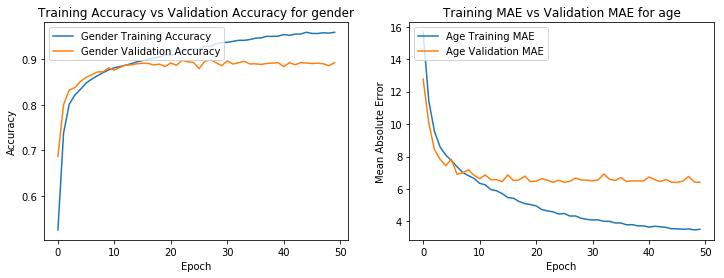

dict_keys(['loss', 'gender_out_loss', 'age_out_loss', 'gender_out_acc', 'gender_out_mean_absolute_error', 'age_out_acc', 'age_out_mean_absolute_error', 'val_loss', 'val_gender_out_loss', 'val_age_out_loss', 'val_gender_out_acc', 'val_gender_out_mean_absolute_error', 'val_age_out_acc', 'val_age_out_mean_absolute_error'])


In [73]:
def plot_accuracy(history):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)
    # Plot accuracy for gender prediction
    ax[0].plot(history.history['gender_out_acc'])
    ax[0].plot(history.history['val_gender_out_acc'])
    ax[0].set_title('Training Accuracy vs Validation Accuracy for gender')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Gender Training Accuracy', 'Gender Validation Accuracy'], loc='upper left')
    
    # Plot accuracy for age prediction
    ax[1].plot(history.history['age_out_mean_absolute_error'])
    ax[1].plot(history.history['val_age_out_mean_absolute_error'])
    ax[1].set_title('Training MAE vs Validation MAE for age')
    ax[1].set_ylabel('Mean Absolute Error')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Age Training MAE', 'Age Validation MAE'], loc='upper left')
    
    
    plt.show()
    
plot_accuracy(history)
# Print the keys in history to check available metrics
print(history.history.keys())

# VGG16

In [74]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow as tf


# Définir le callback
checkpoint_callback = ModelCheckpoint(
    filepath='VGG16Sex.weights.h5',
    monitor='val_gender_output_acc',  # Correct output accuracy for monitoring
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)
checkpoint_callback2 = ModelCheckpoint(
    filepath='VGG16Age.weights.h5',
    monitor='val_age_output_mean_absolute_error',  # Use the correct output accuracy for monitoring
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

# Charger le modèle VGG16
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Ajouter les couches personnalisées
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)
age_output = Dense(1, activation='linear', name='age_output')(x)

# Créer et compiler le modèle
model = Model(inputs=vgg16.input, outputs=[gender_output, age_output])
model.compile(optimizer='adam',
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mean_squared_error'},
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})

# Entraîner le modèle avec un sous-ensemble des données pour les tests
X_sample = X[:100]  # Prenez un sous-ensemble de 100 exemples pour les tests initiaux
y_gender_sample = y_gender[:100]
y_age_sample = y_age[:100]


# Train the model
history = model.fit(x=X, y=[y_gender, y_age], epochs=10, batch_size=32, validation_split=0.2, callbacks=[checkpoint_callback,checkpoint_callback2])



Train on 18966 samples, validate on 4742 samples
Epoch 1/10
18944/18966 [============================>.] - ETA: 4s - loss: 653.1397 - gender_output_loss: 0.7985 - age_output_loss: 652.3413 - gender_output_acc: 0.5093 - age_output_mean_absolute_error: 16.6490 
Epoch 00001: val_gender_output_acc improved from -inf to 0.47933, saving model to VGG16Sex.weights.h5

Epoch 00001: val_age_output_mean_absolute_error improved from inf to 15.31059, saving model to VGG16Age.weights.h5
18966/18966 [==============================] - 4326s 228ms/sample - loss: 652.8802 - gender_output_loss: 0.7983 - age_output_loss: 651.9643 - gender_output_acc: 0.5095 - age_output_mean_absolute_error: 16.6438 - val_loss: 392.5955 - val_gender_output_loss: 0.7397 - val_age_output_loss: 395.4734 - val_gender_output_acc: 0.4793 - val_age_output_mean_absolute_error: 15.3106
Epoch 2/10
18944/18966 [============================>.] - ETA: 4s - loss: 400.4422 - gender_output_loss: 0.7033 - age_output_loss: 399.7389 - gender

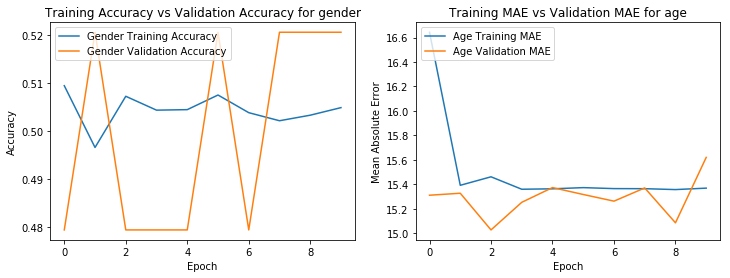

dict_keys(['loss', 'gender_output_loss', 'age_output_loss', 'gender_output_acc', 'age_output_mean_absolute_error', 'val_loss', 'val_gender_output_loss', 'val_age_output_loss', 'val_gender_output_acc', 'val_age_output_mean_absolute_error'])


In [75]:

def plot_accuracy(history):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)
    # Plot accuracy for gender prediction
    ax[0].plot(history.history['gender_output_acc'])
    ax[0].plot(history.history['val_gender_output_acc'])
    ax[0].set_title('Training Accuracy vs Validation Accuracy for gender')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Gender Training Accuracy', 'Gender Validation Accuracy'], loc='upper left')
    
    # Plot accuracy for age prediction
    ax[1].plot(history.history['age_output_mean_absolute_error'])
    ax[1].plot(history.history['val_age_output_mean_absolute_error'])
    ax[1].set_title('Training MAE vs Validation MAE for age')
    ax[1].set_ylabel('Mean Absolute Error')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Age Training MAE', 'Age Validation MAE'], loc='upper left')
    
    
    plt.show()
    
plot_accuracy(history)
# Print the keys in history to check available metrics
print(history.history.keys())

In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Définir l'architecture du modèle avec les noms des couches ajustés
inputs = Input(shape=(64, 64, 3), name='input_17')

# Convolutional layers avec noms ajustés
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_32')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_32')(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu', name='conv2d_33')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_33')(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv2d_34')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_34')(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv2d_35')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_35')(conv_4)

flatten = Flatten(name='flatten_15')(maxp_4)

# Fully connected layers avec noms ajustés
dense_1 = Dense(256, activation='relu', name='dense_23')(flatten)
dense_2 = Dense(256, activation='relu', name='dense_24')(flatten)

dropout_1 = Dropout(0.3, name='dropout_16')(dense_1)
dropout_2 = Dropout(0.3, name='dropout_17')(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out_8')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out_8')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

In [10]:
from tensorflow.keras.models import load_model
model.load_weights(r'C:\Users\Gabriel\Documents\Inge-2I\WebScrapping\MasterProject_GIV\Models\ModelPersonelAge.weights.h5')

model.summary()

ValueError: A total of 9 objects could not be loaded. Example error message for object <Functional name=functional_3, built=True>:

"Unable to synchronously open object (object 'vars' doesn't exist)"

List of objects that could not be loaded:
[<Functional name=functional_3, built=True>, <Conv2D name=conv2d_32, built=True>, <Conv2D name=conv2d_33, built=True>, <Conv2D name=conv2d_34, built=True>, <Conv2D name=conv2d_35, built=True>, <Dense name=dense_23, built=True>, <Dense name=dense_24, built=True>, <Dense name=gender_out_8, built=True>, <Dense name=age_out_8, built=True>]

In [7]:
import h5py

# Chemin vers le fichier de poids
path_to_weights = r'C:\Users\Gabriel\Documents\Inge-2I\WebScrapping\MasterProject_GIV\Models\ModelPersonelAge.weights.h5'

# Ouvrir le fichier de poids avec h5py
with h5py.File(path_to_weights, 'r') as f:
    def print_attrs(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f'Dataset: {name}, shape: {obj.shape}')
        elif isinstance(obj, h5py.Group):
            print(f'Group: {name}')
    
    f.visititems(print_attrs)

Group: age_out
Group: age_out/age_out_8
Dataset: age_out/age_out_8/bias:0, shape: (1,)
Dataset: age_out/age_out_8/kernel:0, shape: (256, 1)
Group: conv2d_32
Group: conv2d_32/conv2d_32
Dataset: conv2d_32/conv2d_32/bias:0, shape: (32,)
Dataset: conv2d_32/conv2d_32/kernel:0, shape: (3, 3, 3, 32)
Group: conv2d_33
Group: conv2d_33/conv2d_33
Dataset: conv2d_33/conv2d_33/bias:0, shape: (64,)
Dataset: conv2d_33/conv2d_33/kernel:0, shape: (3, 3, 32, 64)
Group: conv2d_34
Group: conv2d_34/conv2d_34
Dataset: conv2d_34/conv2d_34/bias:0, shape: (128,)
Dataset: conv2d_34/conv2d_34/kernel:0, shape: (3, 3, 64, 128)
Group: conv2d_35
Group: conv2d_35/conv2d_35
Dataset: conv2d_35/conv2d_35/bias:0, shape: (256,)
Dataset: conv2d_35/conv2d_35/kernel:0, shape: (3, 3, 128, 256)
Group: dense_23
Group: dense_23/dense_23
Dataset: dense_23/dense_23/bias:0, shape: (256,)
Dataset: dense_23/dense_23/kernel:0, shape: (9216, 256)
Group: dense_24
Group: dense_24/dense_24
Dataset: dense_24/dense_24/bias:0, shape: (256,)


In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Définir l'architecture du modèle avec les noms des couches ajustés
inputs = Input(shape=(64, 64, 3), name='input_17')

# Convolutional layers avec noms ajustés
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_32')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_32')(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu', name='conv2d_33')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_33')(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv2d_34')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_34')(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv2d_35')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_35')(conv_4)

flatten = Flatten(name='flatten_15')(maxp_4)

# Fully connected layers avec noms ajustés
dense_1 = Dense(256, activation='relu', name='dense_23')(flatten)
dense_2 = Dense(256, activation='relu', name='dense_24')(flatten)

dropout_1 = Dropout(0.3, name='dropout_16')(dense_1)
dropout_2 = Dropout(0.3, name='dropout_17')(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out_8')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out_8')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

# Charger les poids
path_to_weights = r'C:\Users\Gabriel\Documents\Inge-2I\WebScrapping\MasterProject_GIV\Models\ModelPersonelAge.weights.h5'
model.load_weights(path_to_weights)

# Afficher le résumé du modèle
model.summary()


ValueError: A total of 9 objects could not be loaded. Example error message for object <Functional name=functional_5, built=True>:

"Unable to synchronously open object (object 'vars' doesn't exist)"

List of objects that could not be loaded:
[<Functional name=functional_5, built=True>, <Conv2D name=conv2d_32, built=True>, <Conv2D name=conv2d_33, built=True>, <Conv2D name=conv2d_34, built=True>, <Conv2D name=conv2d_35, built=True>, <Dense name=dense_23, built=True>, <Dense name=dense_24, built=True>, <Dense name=gender_out_8, built=True>, <Dense name=age_out_8, built=True>]

In [17]:
import h5py
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Inspection des poids pour vérifier les noms
with h5py.File(r'C:\Users\Gabriel\Documents\Inge-2I\WebScrapping\MasterProject_GIV\Models\ModelPersonelAge.weights.h5', 'r') as f:
    def print_structure(name, obj):
        if isinstance(obj, h5py.Group):
            print(f"Group: {name}")
        elif isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name}, shape: {obj.shape}")
    f.visititems(print_structure)

# Définir l'architecture du modèle avec les noms des couches ajustés
inputs = Input(shape=(64, 64, 3), name='input_17')

# Convolutional layers avec noms ajustés
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_32')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_32')(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu', name='conv2d_33')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_33')(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv2d_34')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_34')(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv2d_35')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_35')(conv_4)

flatten = Flatten(name='flatten_15')(maxp_4)

# Fully connected layers avec noms ajustés
dense_1 = Dense(256, activation='relu', name='dense_23')(flatten)
dense_2 = Dense(256, activation='relu', name='dense_24')(flatten)

dropout_1 = Dropout(0.3, name='dropout_16')(dense_1)
dropout_2 = Dropout(0.3, name='dropout_17')(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out_8')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out_8')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

# Charger les poids
path_to_weights = r'C:\Users\Gabriel\Documents\Inge-2I\WebScrapping\MasterProject_GIV\Models\ModelPersonelAge.weights.h5'
model.load_weights(path_to_weights, skip_mismatch=True)

# Afficher le résumé du modèle
model.summary()

Group: age_out
Group: age_out/age_out_8
Dataset: age_out/age_out_8/bias:0, shape: (1,)
Dataset: age_out/age_out_8/kernel:0, shape: (256, 1)
Group: conv2d_32
Group: conv2d_32/conv2d_32
Dataset: conv2d_32/conv2d_32/bias:0, shape: (32,)
Dataset: conv2d_32/conv2d_32/kernel:0, shape: (3, 3, 3, 32)
Group: conv2d_33
Group: conv2d_33/conv2d_33
Dataset: conv2d_33/conv2d_33/bias:0, shape: (64,)
Dataset: conv2d_33/conv2d_33/kernel:0, shape: (3, 3, 32, 64)
Group: conv2d_34
Group: conv2d_34/conv2d_34
Dataset: conv2d_34/conv2d_34/bias:0, shape: (128,)
Dataset: conv2d_34/conv2d_34/kernel:0, shape: (3, 3, 64, 128)
Group: conv2d_35
Group: conv2d_35/conv2d_35
Dataset: conv2d_35/conv2d_35/bias:0, shape: (256,)
Dataset: conv2d_35/conv2d_35/kernel:0, shape: (3, 3, 128, 256)
Group: dense_23
Group: dense_23/dense_23
Dataset: dense_23/dense_23/bias:0, shape: (256,)
Dataset: dense_23/dense_23/kernel:0, shape: (9216, 256)
Group: dense_24
Group: dense_24/dense_24
Dataset: dense_24/dense_24/bias:0, shape: (256,)


C:\Users\Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\saving\saving_lib.py:293: UserWarning: A total of 9 objects could not be loaded. Example error message for object <Functional name=functional_13, built=True>:

"Unable to synchronously open object (object 'vars' doesn't exist)"

List of objects that could not be loaded:
[<Functional name=functional_13, built=True>, <Conv2D name=conv2d_32, built=True>, <Conv2D name=conv2d_33, built=True>, <Conv2D name=conv2d_34, built=True>, <Conv2D name=conv2d_35, built=True>, <Dense name=dense_23, built=True>, <Dense name=dense_24, built=True>, <Dense name=gender_out_8, built=True>, <Dense name=age_out_8, built=True>]
  warnings.warn(msg)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_17            │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 62, 62,    │        896 │ input_17[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 31, 31,    │          0 │ conv2d_32[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 29, 29,    │     18,496 │ max_pooling2d_32… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 14, 14,    │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 12, 12,    │     73,856 │ max_pooling2d_33… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_34    │ (None, 6, 6, 128) │          0 │ conv2d_34[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 4, 4, 256) │    295,168 │ max_pooling2d_34… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_35    │ (None, 2, 2, 256) │          0 │ conv2d_35[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 1024)      │          0 │ max_pooling2d_35… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 256)       │    262,400 │ flatten_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 256)       │    262,400 │ flatten_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 256)       │          0 │ dense_23[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 256)       │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out_8        │ (None, 1)         │        257 │ dropout_16[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out_8 (Dense)   │ (None, 1)         │        257 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 913,730 (3.49 MB)

 Trainable params: 913,730 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prédiction du genre (0 pour homme, 1 pour femme) : [[0.3235286]]
Prédiction de l'âge : [[55.907978]]


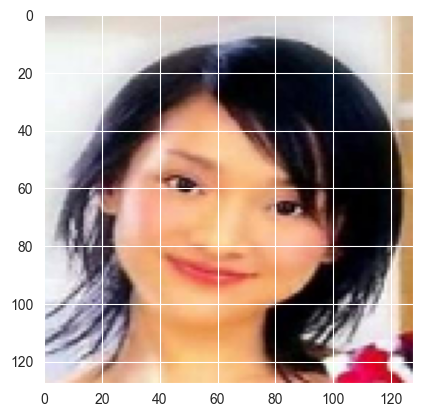

In [63]:
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input, decode_predictions
import numpy as np

# Charger l'image et la redimensionner à la taille attendue par le modèle
img_path = r"C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset\22_1_2_20170116172700901.jpg"
img = image.load_img(img_path, target_size=(128, 128))

# Convertir l'image en tableau numpy
img_array = image.img_to_array(img)

# Élargir les dimensions de l'image pour correspondre à celles attendues par le modèle
img_array = np.expand_dims(img_array, axis=0)

# Prétraiter l'image
img_array = preprocess_input(img_array)

# Faire la prédiction
prediction_sexe = model_sexe.predict(img_array)
prediction_age = model_age.predict(img_array)

# Décoder les prédictions
gender_prediction = prediction_sexe[0]
age_prediction = prediction_age[1]

# Afficher les résultats
plt.imshow(img);
print("Prédiction du genre (0 pour homme, 1 pour femme) :", gender_prediction)
print("Prédiction de l'âge :", age_prediction)



In [47]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import mae

# Charger le modèle en spécifiant les métriques personnalisées
model_age = load_model(r"C:\Users\Gabriel\Documents\Inge-2I\WebScrapping\MasterProject_GIV\Models\ModelPersonelAge.h5", custom_objects={'mae': mae})

# Afficher un résumé du modèle
model_age.summary()



Model: "model_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_4             │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 126, 126,  │        896 │ input_4[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 63, 63,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 61, 61,    │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 30, 30,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 28, 28,    │     73,856 │ max_pooling2d_13… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 14, 14,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 12, 12,    │    295,168 │ max_pooling2d_14… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 6, 6, 256) │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 9216)      │          0 │ max_pooling2d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │  2,359,552 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │  2,359,552 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,108,036 (19.49 MB)

 Trainable params: 5,108,034 (19.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [46]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import mae

# Charger le modèle en spécifiant les métriques personnalisées
model_sexe = load_model(r"C:\Users\Gabriel\Documents\Inge-2I\WebScrapping\MasterProject_GIV\Models\ModelPersonelSex.h5", custom_objects={'mae': mae})

# Afficher un résumé du modèle
model_sexe.summary()


Model: "model_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_4             │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 126, 126,  │        896 │ input_4[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 63, 63,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 61, 61,    │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 30, 30,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 28, 28,    │     73,856 │ max_pooling2d_13… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 14, 14,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 12, 12,    │    295,168 │ max_pooling2d_14… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 6, 6, 256) │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 9216)      │          0 │ max_pooling2d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │  2,359,552 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │  2,359,552 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,108,036 (19.49 MB)

 Trainable params: 5,108,034 (19.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [53]:
#random number for get image
image_index = 35
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
#predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

NameError: name 'y_gender' is not defined